In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Functions and helpers

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, GRU
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

2023-04-09 12:41:22.628088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 12:41:22.737217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-09 12:41:22.737236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not 

# Gated Recurrent Units (GRU)

## Model

In [3]:
# Create the RNN model with GRU units
def create_model(units=50, look_back=26, activation="relu",num_hidden_layers=3, optimizer='adam'):
    model = Sequential()
    # Layer 1
    if((activation == None)):
        model.add(GRU(units=units, input_shape=(look_back, 1), return_sequences=True))
    else:
        model.add(GRU(units=units, activation=activation, input_shape=(look_back, 1), return_sequences=True))
    
    # Middle layers
    for i in range(num_hidden_layers-2):
        if((activation == None)):
            model.add(GRU(units=units, return_sequences=True))
        else:
            model.add(GRU(units=units, activation=activation, return_sequences=True))
    
    if(num_hidden_layers>2):
        if((activation == None)):
            model.add(GRU(units=units))
        else:
            model.add(GRU(units=units, activation=activation))
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model
   

# Prepare the input and output for the RNN model
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : (i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [4]:
# Load and preprocess the data
station = 235
data = get_specific_station_data(station,'4w',1800)

# Scale data
scaler = MinMaxScaler()
precipitation = data.precipitation.values
precipitation = scaler.fit_transform(precipitation.reshape(-1, 1))

look_back = 26
X, y = prepare_data(precipitation, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

# Train the model using defaults
model = create_model(look_back=look_back)
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


2023-04-09 12:41:27.997594: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-09 12:41:27.997637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rmsryu-vm): /proc/driver/nvidia/version does not exist
2023-04-09 12:41:27.998342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
31/31 [==============================] - 3s 23ms/step - loss: 0.0338
Epoch 2/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0204
Epoch 3/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0204
Epoch 4/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0201
Epoch 5/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0202
Epoch 6/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0200
Epoch 7/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0200
Epoch 8/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0199
Epoch 9/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0197
Epoch 10/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0196
Epoch 11/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0194
Epoch 12/30
31/31 [==============================] - 1s 23ms/step - loss: 0.0193
Epoch 13/30
31/31 [==================

RMSE: 0.12462940812110901


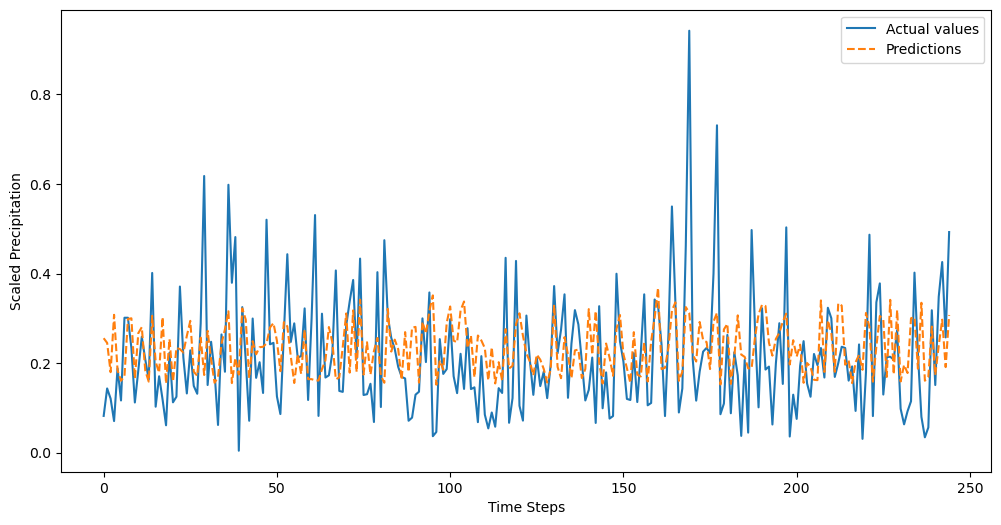

In [5]:
import matplotlib.pyplot as plt
print(f"RMSE: {rmse}")
plt.figure(figsize=(12, 6))
plt.plot(y_test, label=f'Actual values')
plt.plot(y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()

## Hyper parameters

In [6]:
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
# KerasRegressor to wrap the create_model function
# model = KerasRegressor(build_fn=create_model_t, verbose=0)
model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'units': [3, 5, 12, 26, 32, 50, 70],
    'activation' :  [None,'tanh','relu'],
    'optimizer': ['adam','rmsrop','adadelta'],
    'num_hidden_layers': [3,5,7]
}

param_grid = {
    'units': [26,50],
    'activation' :  ['relu','tanh'],
    'optimizer': ['adam','rmsrop'],
    'num_hidden_layers': [3,5,7]
}

print(param_grid)
# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X, y)

# Print the results
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/tmp/ipykernel_99103/2514906908.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


{'units': [26, 50], 'activation': ['relu', 'tanh'], 'optimizer': ['adam', 'rmsrop'], 'num_hidden_layers': [3, 5, 7]}


/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "/tmp/ipykernel_99103/1877065813.py", line 24, in create_model
    model.compile(optimizer=o

Best score: -0.018226 using {'activation': 'tanh', 'num_hidden_layers': 7, 'optimizer': 'adam', 'units': 50}


In [9]:
grid_result.best_params_

{'activation': 'tanh',
 'num_hidden_layers': 7,
 'optimizer': 'adam',
 'units': 50}